## Семинар 7: "Методы оптимизации"

ФИО:  Устинов Иван Вадимович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [130]:
class GD:
    """  Gradient Descent  """
    def __init__(self, x, f, df, lr):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(lr=lr)
        
    def __call__(self):
        self.x -= self.df(self.x) * self.params['lr'] 
        return self.x
    
class Momentum:
    """  Momentum  """
    def __init__(self, x, f, df, lr, gamma):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(lr=lr, gamma=gamma)
        self.prev_grad = np.zeros(self.x.shape)
        self.grad = np.zeros(self.x.shape)
        
    def __call__(self):
        self.grad = self.prev_grad * self.params['gamma'] \
                    + self.params['lr'] * self.df(self.x)
        self.x -= self.grad
        self.prev_grad = self.grad
        return self.x
    
class NAG:
    """  NAG  """
    def __init__(self, x, f, df, lr, gamma):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(lr=lr, gamma=gamma)
        self.prev_grad = np.zeros(self.x.shape)
        self.grad = np.zeros(self.x.shape)
    
    def __call__(self):
        prev_step = self.prev_grad * self.params['gamma']
        self.grad = prev_step + self.params['lr'] * self.df(self.x - prev_step)
        self.x -= self.grad
        self.prev_grad = self.grad
        return self.x

In [313]:
class Adagrad:
    """  Adagrad  """
    def __init__(self, x, f, df, lr):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(lr=lr)
        
        self.grad = np.zeros(self.x.shape)
        self.G = np.zeros(self.x.shape) + 0.1
        
    def __call__(self):
        self.grad = self.df(self.x)
        self.G += self.grad ** 2
        self.x -= self.params['lr'] * self.grad / np.sqrt(self.G)
        return self.x
    
class Adadelta:
    """  Adadelta  """
    def __init__(self, x, f, df, ro):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(ro=ro)
        
        self.grad = np.zeros(self.x.shape)
        self.u = np.zeros(self.x.shape) + 0.01
        self.G = np.zeros(self.x.shape) + 0.01
        self.U = np.zeros(self.x.shape)

    def __call__(self):
        self.grad = self.df(self.x)
        self.G = self.G * self.params['ro'] + (1-self.params['ro']) * self.grad ** 2
        self.U = self.U * self.params['ro'] + (1-self.params['ro']) * self.u ** 2
        
        self.u = np.sqrt(self.U) * self.grad / np.sqrt(self.G)
        self.x -= self.u
        return self.x
    
class Adam:
    """  Adam  """
    def __init__(self, x, f, df, lr, ro, beta1=0.9, beta2=0.999):
        self.x = np.array(x).astype('float64')
        self.f = f
        self.df = df
        self.params = dict(lr=lr, ro=ro, b1=beta1, b2=beta2)
        
        self.grad = np.zeros(self.x.shape)
        self.u = np.zeros(self.x.shape) + 0.01
        self.v = np.zeros(self.x.shape)
        self.m = np.zeros(self.x.shape)
        self.t = 0
        
    def __call__(self):
        self.t += 1
        self.grad = self.df(self.x)
        self.m = self.m * self.params['b1'] + (1-self.params['b1']) * self.grad
        self.v = self.v * self.params['b2'] + (1-self.params['b2']) * (self.grad ** 2)
        
        m_ = self.m / (1 - self.params['b1'] ** self.t)
        v_ = self.v / (1 - self.params['b2'] ** self.t)
        
        self.u = self.params['lr']  * m_ / np.sqrt(v_ + 0.00000001)
        self.x -= self.u
        return self.x

In [327]:
def draw_grad(_opt, x, f, df, *args):
    opt = _opt(x, f, df, *args)
    e = 0.0001
    numbers = []
    for i in range(500):
        val = opt()
        numbers.append(np.array(val))
#         if i > 1 and np.abs(np.sum(numbers[i]-numbers[i-1])) < e:
#             break
    numbers = np.array(numbers)
    x, y = np.meshgrid(np.linspace(-10,10,200), np.linspace(-10,10,200))
    print(_opt.__doc__)
    plt.contour(x, y, f([x, y]), 20)
    plt.scatter(numbers[:, 0], numbers[:, 1])
    plt.scatter(numbers[-1, 0], numbers[-1, 1], c='red')
    plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

  Gradient Descent  


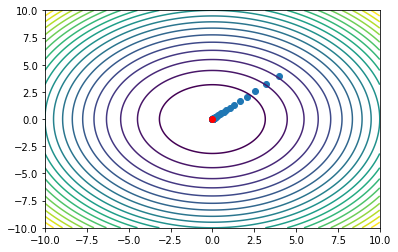

  Momentum  


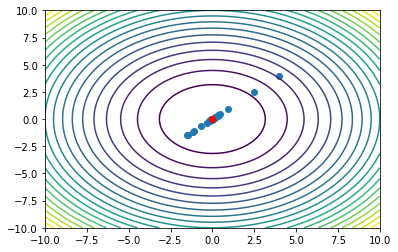

  NAG  


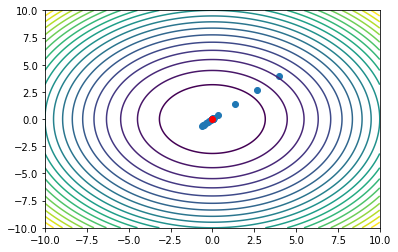

In [304]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

draw_grad(GD, [5, 5], f, df, 0.1)
draw_grad(Momentum, [5, 5], f, df, 0.1, 0.7)
draw_grad(NAG, [5, 5], f, df, 0.1, 0.7)

  Adagrad  


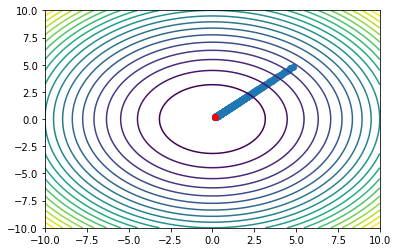

  Adadelta  


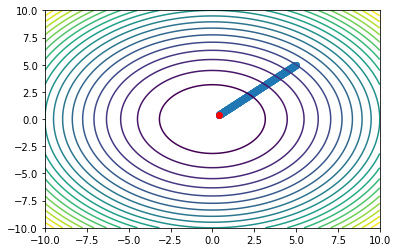

  Adam  


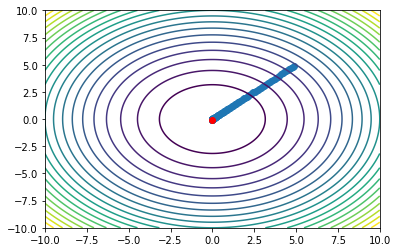

In [321]:
draw_grad(Adagrad, [5,5], f, df, 0.2)
draw_grad(Adadelta, [5,5], f, df, 0.1)
draw_grad(Adam, [5,5], f, df, 0.1, 0.7)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

  Gradient Descent  


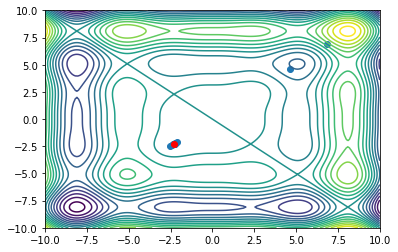

  Momentum  


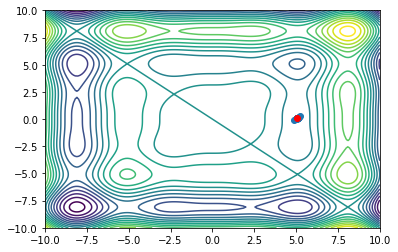

  NAG  


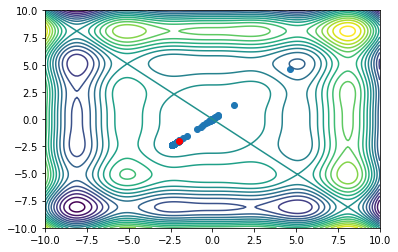

In [330]:
f = lambda X: X[0]**2 * np.sin(X[0]) + X[1]**2 * np.sin(X[1])
df = lambda X: 2 * X[0] * np.sin(X[0]) + X[0]**2 * np.cos(X[0]) \
               + 2 * X[1] * np.sin(X[1]) + X[1]**2 * np.cos(X[1])

draw_grad(GD, [3, 3], f, df, 0.1)
draw_grad(Momentum, [5, 0], f, df, 0.1, 0.7)
draw_grad(NAG, [3, 3], f, df, 0.1, 0.7)

  Adagrad  


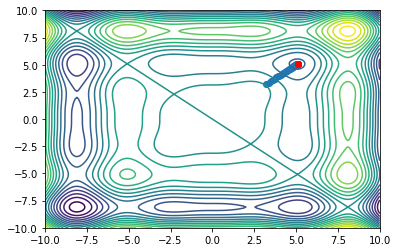

  Adadelta  


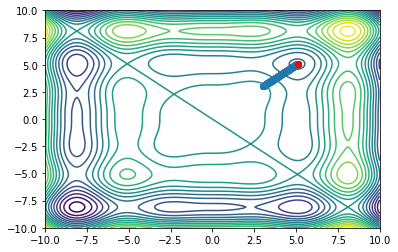

  Adam  


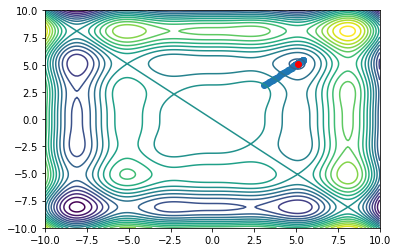

In [337]:
draw_grad(Adagrad, [3,3], f, df, 0.2)
draw_grad(Adadelta, [3,3], f, df, 0.1)
draw_grad(Adam, [3,3], f, df, 0.1, 0.7)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

  Gradient Descent  


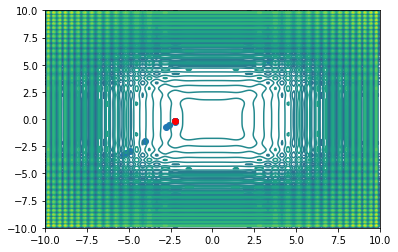

  Momentum  


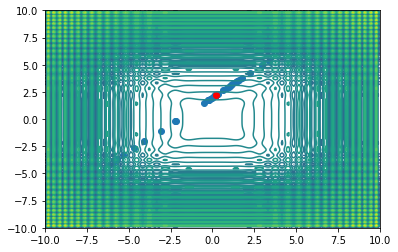

  NAG  


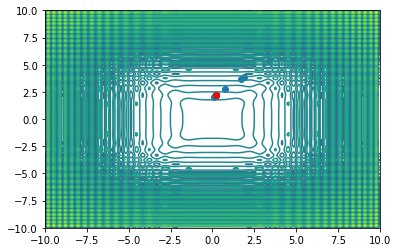

In [351]:
f = lambda X: X[0]**2 * np.sin(X[0]**2) + X[1]**2 * np.sin(X[1]**2)
df = lambda X: 2 * X[0] * np.sin(X[0]**2) + X[0]**2 * np.cos(X[0]**2) * 2 * X[0] \
               + 2 * X[1] * np.sin(X[1]**2) + X[1]**2 * np.cos(X[1]**2) * 2 * X[1]

draw_grad(GD, [2, 4], f, df, 0.01)
draw_grad(Momentum, [2, 4], f, df, 0.01, 0.5)
draw_grad(NAG, [2, 4], f, df, 0.01, 0.5)

  Adagrad  


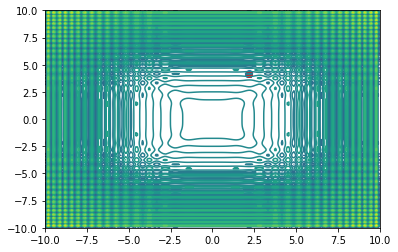

  Adadelta  


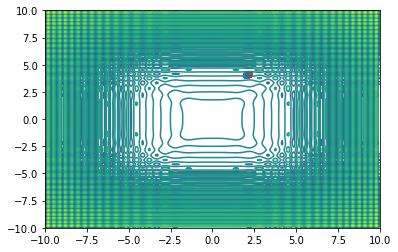

  Adam  


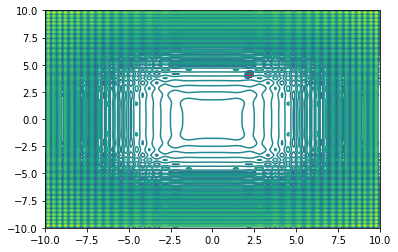

In [363]:
draw_grad(Adagrad, [2,4], f, df, 0.2)
draw_grad(Adadelta, [2,4], f, df, 0.1)
draw_grad(Adam, [2,4], f, df, 0.05, 0.7)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [365]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from tqdm import tqdm

In [455]:
dataset = datasets.MNIST(download=True, train=True, root='./data', transform=Compose([ToTensor()]))
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)
epoch=4

model_linear = nn.Sequential(nn.Linear(28*28, 64), nn.Linear(64, 10), nn.LogSoftmax())
# model_linear
loss_func = nn.NLLLoss()
opt_adam = torch.optim.Adam(model_linear.parameters())
opt_adagrad = torch.optim.Adagrad(model_linear.parameters())
opt_adadeltd = torch.optim.Adadelta(model_linear.parameters())
opt_sgd = torch.optim.SGD(model_linear.parameters(), lr=0.01)

In [456]:
def test_opt(opt):
    losses = []
    for e in range(epoch):
        for x, y in dataloader:
            x = torch.FloatTensor(x).view(x.shape[0], -1)
            y = Variable(torch.LongTensor(y))
            y_pred = model_linear(Variable(x))

            loss = loss_func(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(np.array(loss.cpu().data))
    return losses

In [457]:
%%time
adam_loss = test_opt(opt_adam)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 9min 24s, sys: 2.22 s, total: 9min 27s
Wall time: 49.1 s


In [458]:
%%time
adagrad_loss = test_opt(opt_adagrad)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 9min 13s, sys: 2.03 s, total: 9min 15s
Wall time: 47.2 s


In [459]:
%%time
adadelta_loss = test_opt(opt_adadeltd)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 9min 28s, sys: 2.06 s, total: 9min 31s
Wall time: 49.1 s


In [460]:
%%time
sgd_loss = test_opt(opt_sgd)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 8min 49s, sys: 2.09 s, total: 8min 51s
Wall time: 44.3 s


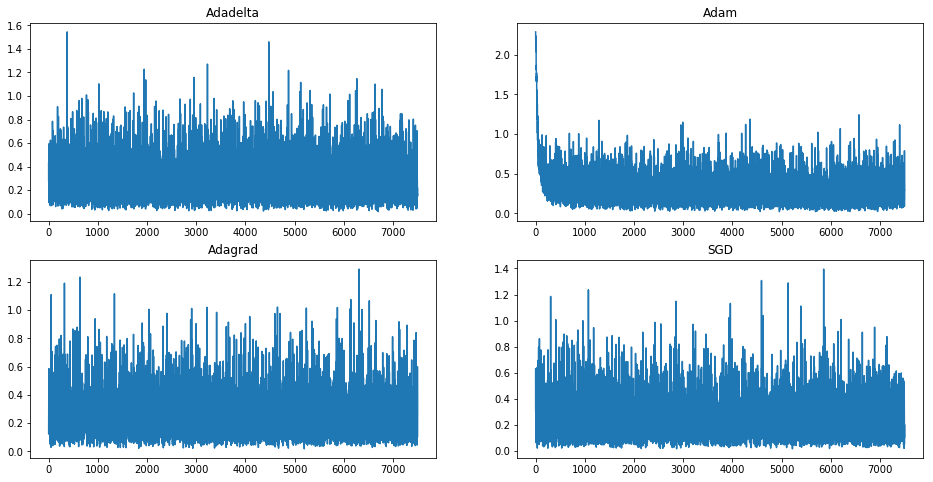

In [461]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_loss)
plt.title("SGD")

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [467]:
model_conv = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
model_linear = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
params = list(model_conv.parameters()) + list(model_linear.parameters())

opt_adam = torch.optim.Adam(params)
opt_adagrad = torch.optim.Adagrad(params)
opt_adadeltd = torch.optim.Adadelta(params)
opt_sgd = torch.optim.SGD(params, lr=0.01)

def test_opt(opt):
    losses = []
    for e in range(epoch):
        for x, y in dataloader:
            x = torch.FloatTensor(x).view(x.shape[0], 1, 28, 28)
            y = Variable(torch.LongTensor(y))
            
            x = model_conv(Variable(x))
            y_pred = model_linear(x.view(x.shape[0], -1))

            loss = loss_func(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(np.array(loss.cpu().data))
    return losses

In [468]:
%%time
adam_loss = test_opt(opt_adam)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 14min 22s, sys: 8.01 s, total: 14min 30s
Wall time: 1min 25s


In [469]:
%%time
adagrad_loss = test_opt(opt_adagrad)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 14min 6s, sys: 7.71 s, total: 14min 14s
Wall time: 1min 22s


In [470]:
%%time
adadelta_loss = test_opt(opt_adadeltd)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 14min 15s, sys: 8.5 s, total: 14min 23s
Wall time: 1min 26s


In [471]:
%%time
sgd_loss = test_opt(opt_sgd)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 13min 57s, sys: 8.09 s, total: 14min 5s
Wall time: 1min 20s


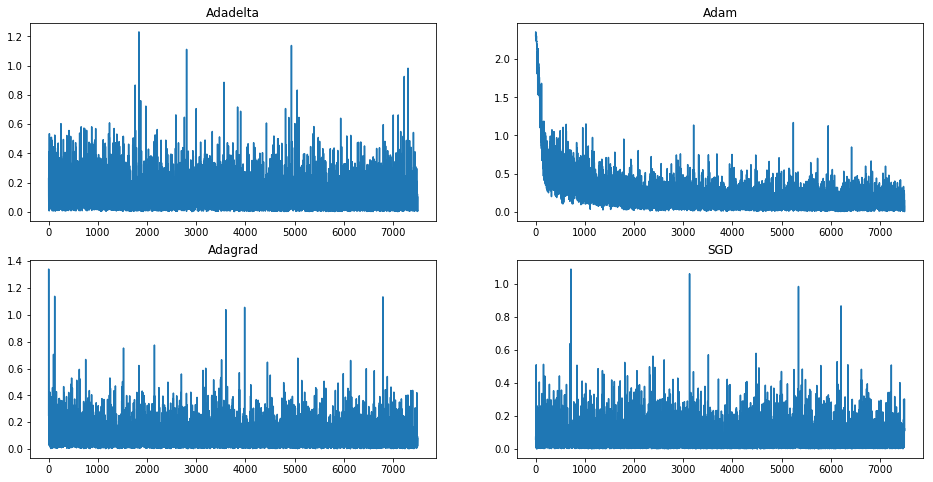

In [472]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_loss)
plt.title("SGD")

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: